#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час.


Необходимо:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


## Подготовка

Импорт библиотек

In [1]:
import os
import numpy as np
import pandas as pd
import lightgbm as lgb
import plotly.express as px
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split, TimeSeriesSplit
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose


import warnings
warnings.filterwarnings("ignore", category = DeprecationWarning)

Загрузка данных

In [2]:
way_0 = r"..\\forecasting-taxi-orders\\taxi.csv"
way_1 = '/datasets/taxi.csv'
if os.path.exists(way_0):
    df = pd.read_csv(way_0, index_col = [0], parse_dates = [0])
elif os.path.exists(way_1):
    df = pd.read_csv(way_1, index_col = [0], parse_dates = [0])
else:
    print('Ошибка (o_O)')

Проверим, что данные загрузили корректно

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Выполним ресемплирование данных по одному часу

In [4]:
df.sort_index(inplace = True)
df = df.resample('1H').sum()

## Анализ

Посмотри на распределение целевого признака

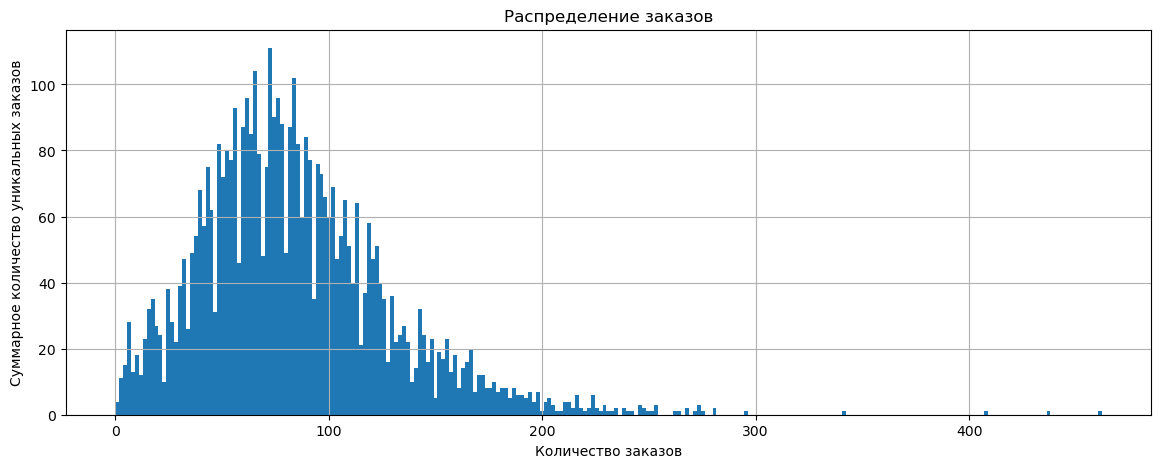

In [5]:
df['num_orders'].hist(bins = df['num_orders'].unique().shape[0], figsize = (14, 5));
plt.title('Распределение заказов');
plt.xlabel('Количество заказов');
plt.ylabel('Суммарное количество уникальных заказов');

In [6]:
df['num_orders'].describe()

count    4416.000000
mean       84.422781
std        45.023853
min         0.000000
25%        54.000000
50%        78.000000
75%       107.000000
max       462.000000
Name: num_orders, dtype: float64

Выбросами можно считать влияние случайных необъяснимых факторов. Здесь же количество измерено точно по вызовам такси. Считаю, что удалять ничего не стоит

Посмотрим основные составляющие временного ряда так как: тренд, сезонная составляющая и остаток декомпозиции

In [7]:
decomposed = seasonal_decompose(df)

Построим графики для составляющего ряда

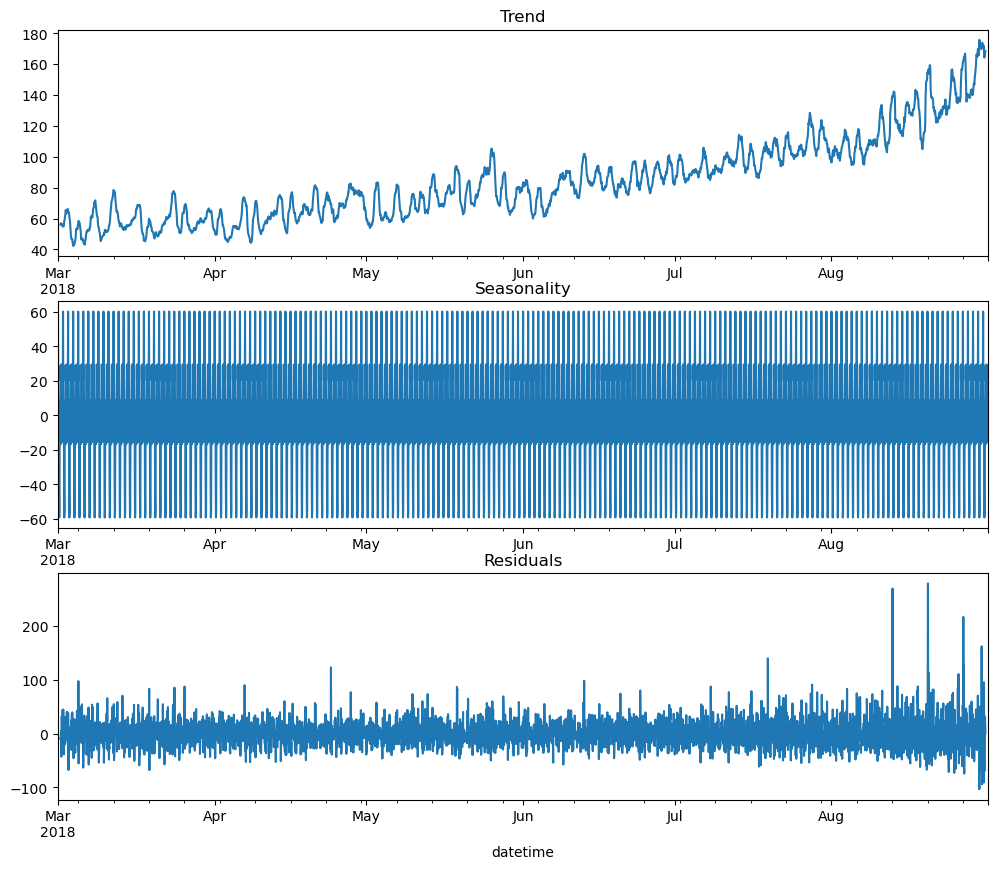

In [8]:
plt.figure(figsize = (12, 10))
plt.subplot(311)
decomposed.trend.plot(ax = plt.gca());
plt.title('Trend');
plt.subplot(312)
decomposed.seasonal.plot(ax = plt.gca());
plt.title('Seasonality');
plt.subplot(313)
decomposed.resid.plot(ax = plt.gca());
plt.title('Residuals');

Графики показывают высокую частотность, уменьшим интервал и посмотри за неделю

In [9]:
decomposed = seasonal_decompose(df['2018-03-01': '2018-03-08'])

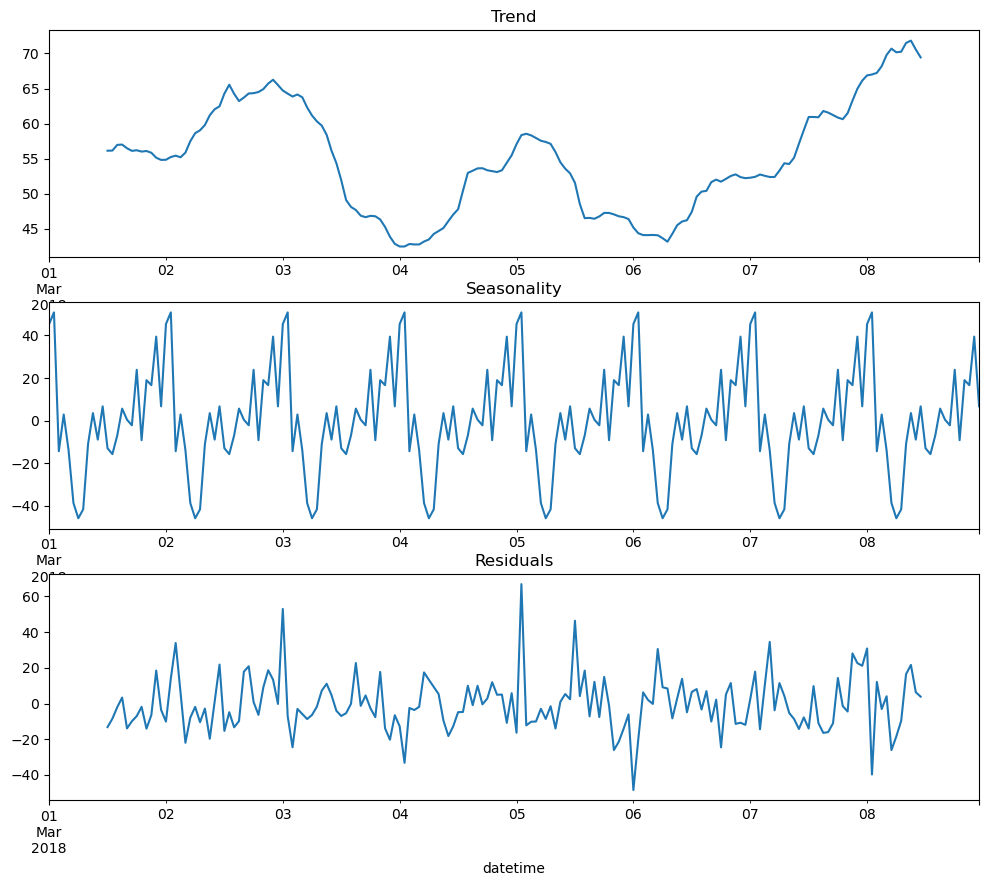

In [10]:
plt.figure(figsize = (12, 10))
plt.subplot(311)
decomposed.trend.plot(ax = plt.gca());
plt.title('Trend');
plt.subplot(312)
decomposed.seasonal.plot(ax = plt.gca());
plt.title('Seasonality');
plt.subplot(313)
decomposed.resid.plot(ax = plt.gca());
plt.title('Residuals');

Теперь уменьшим интервал и посмотри за день

In [11]:
decomposed = seasonal_decompose(df['2018-03-01': '2018-03-02'])

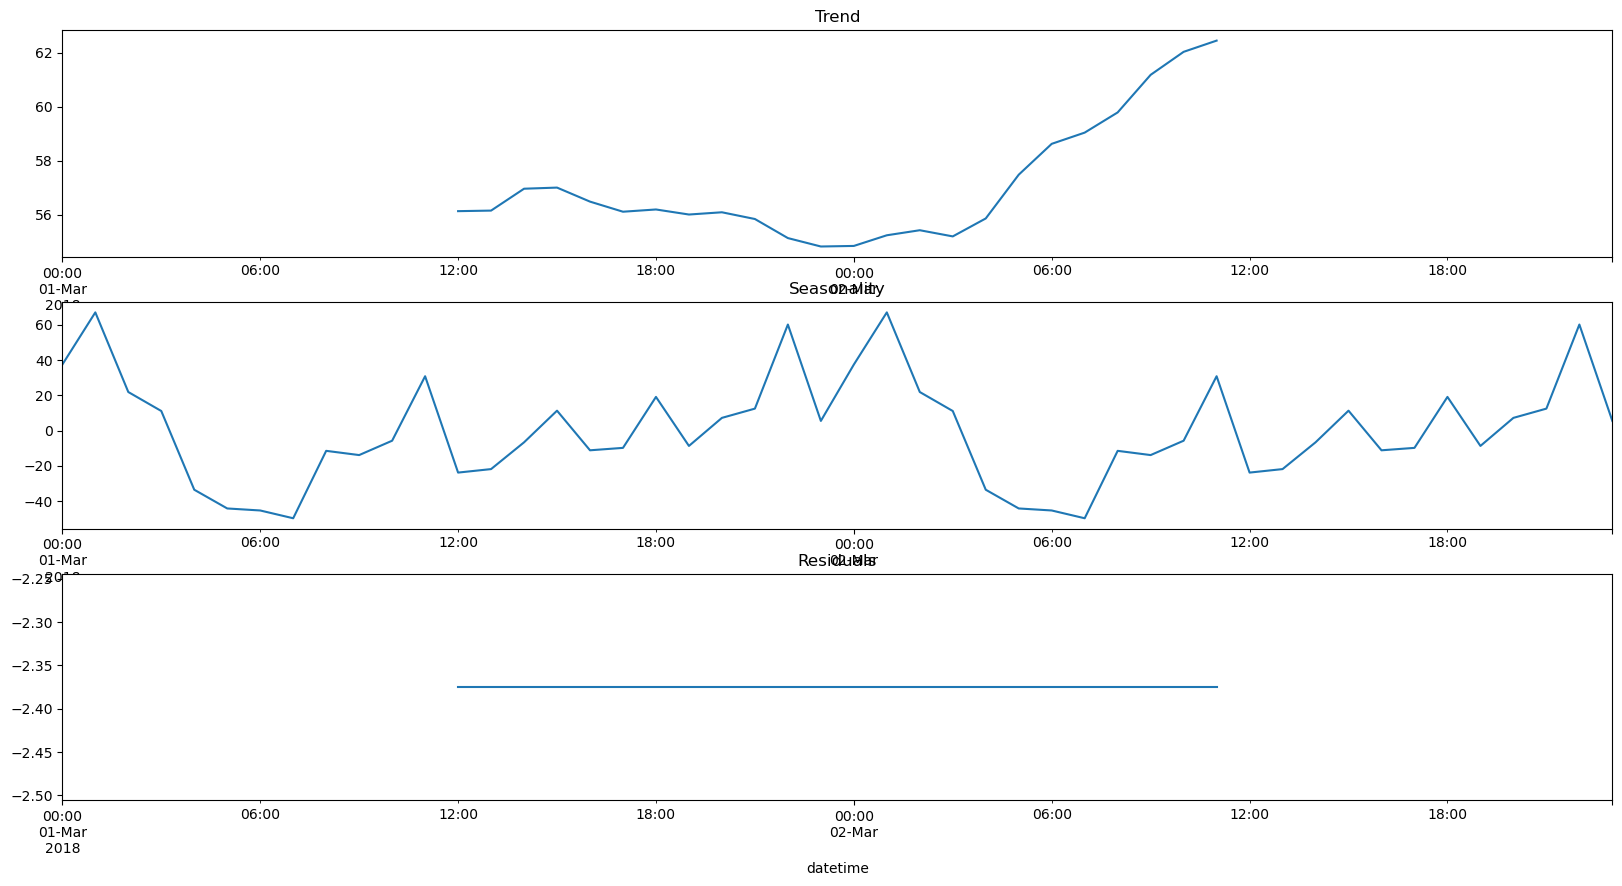

In [12]:
plt.figure(figsize = (20, 10))
plt.subplot(311)
decomposed.trend.plot(ax = plt.gca());
plt.title('Trend');
plt.subplot(312)
decomposed.seasonal.plot(ax = plt.gca());
plt.title('Seasonality');
plt.subplot(313)
decomposed.resid.plot(ax = plt.gca());
plt.title('Residuals');

Теперь явно видна суточная сезонность. Ночью количество заказов стремится к нулю, в то время как вечерний час пик - момент самого сильного спроса на услуги такси.

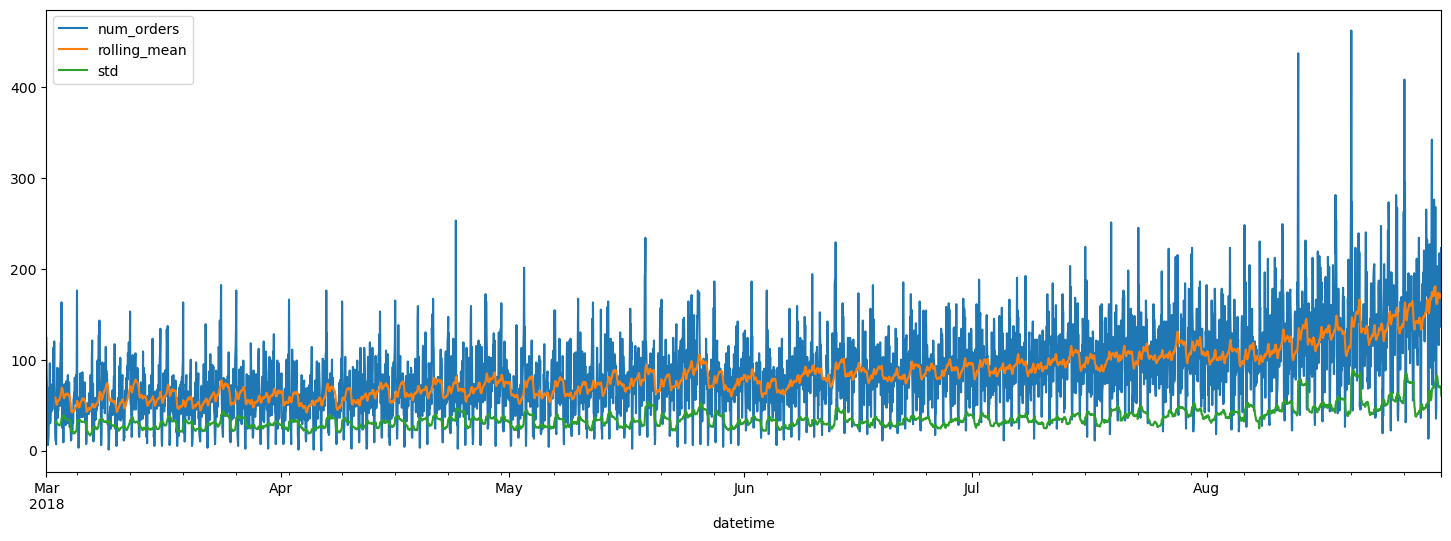

In [13]:
df_plot = df.copy()
df_plot['rolling_mean'] = df_plot.rolling(30).mean()
df_plot['std'] = df_plot['num_orders'].rolling(30).std()
df_plot.plot(figsize=(18, 6));

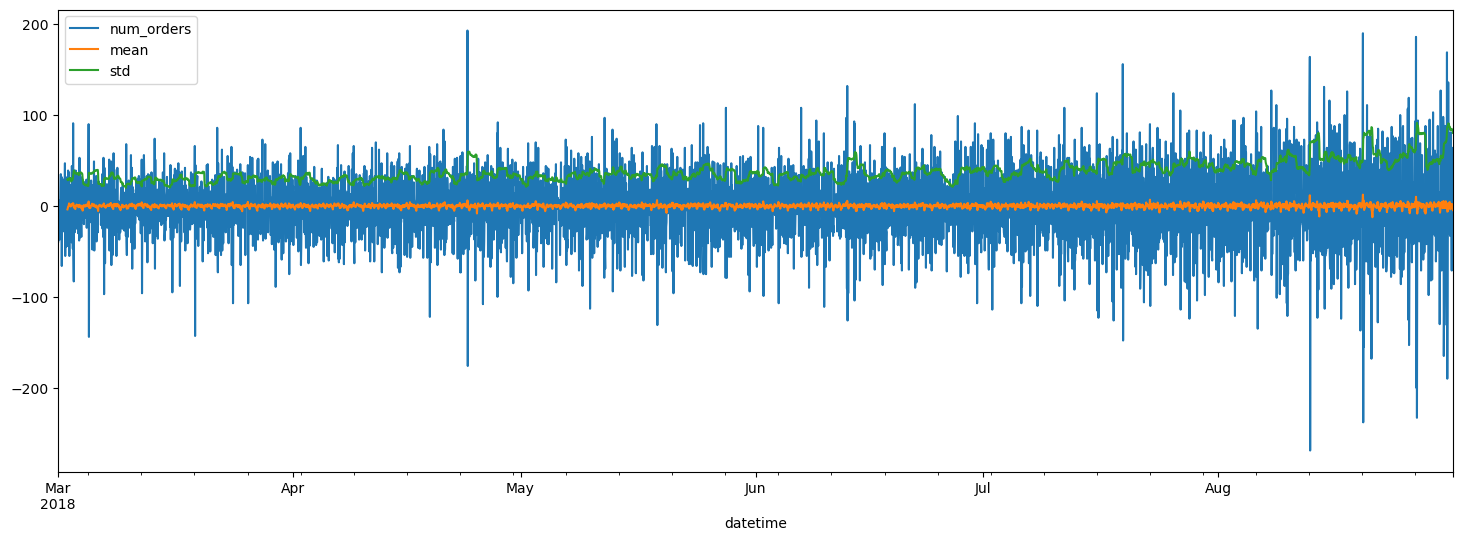

In [14]:
df_shift = df - df.shift()
df_shift['mean'] = df_shift['num_orders'].rolling(30).mean()
df_shift['std'] = df_shift['num_orders'].rolling(30).std()
df_shift.plot(figsize=(18, 6));

**Промежуточный вывод**  

На этом этапе проведен анализ данных. Методом декомпозиции были выделены следующие аспекты:

- За время наблюдений наметился определенный тренд на общее увеличение заказов такси в течение часа, которое скорее всего вызвано ростом компании, поскольку есть гипотеза, что бизнес, связанный с такси не имеет месячной сезонности. Но данную гипотезу можно подтвердить или опровергнуть только имея данные за несколько лет.  
- На графиках явно видна суточная сезонность. Ночью количество заказов стремится к нулю, в то время как вечерний час пик - момент самого сильного спроса на услуги такси.

Напишем функцию для создания признаков

In [15]:
def make_features(data, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    data = data.fillna('-1')
# Применим функцию с лагом до 24 часов и 100-м скользящим средним
make_features(df, 24, 100)

Удалим все пропуски

In [17]:
df = df.dropna()

Необходимо отделить целевой признак

In [18]:
target = df['num_orders']
features = df.drop('num_orders', axis = 1)

Выполним сплит данных

In [19]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size = 0.1
)

Проверим правильно ли разделены данные

In [20]:
print(f'features_train: {features_train.shape}')
print(f'fetures_test: {features_test.shape}')
print(f'target_train: {target_train.shape}')
print(f'target_test: {target_test.shape}')

features_train: (3884, 28)
fetures_test: (432, 28)
target_train: (3884,)
target_test: (432,)


## Обучение

Для обучения рассмотрим 3 модели: LightGBM, RandomForestRegressor, DecisionTreeRegressor. Так как нам необходимо предсказывать количество заказов на следующий час, то выбирать наилучшую модель мы будем по времени предсказания и качеству метрики

**Инициализация модели DecisionTreeRegressor**

In [21]:
tscv = TimeSeriesSplit(n_splits = 5)
model_dtr = DecisionTreeRegressor(random_state = 12345)
parameters = {
    'max_depth' : [x for x in range(1, 8)],
    'min_samples_split' : [x for x in np.arange(0.1, 1, 0.1)],
    'min_samples_leaf' : [x for x in range(1, 5)]
}
grid_model_dtr = GridSearchCV(model_dtr,
                              parameters,
                              cv = tscv,
                              scoring = 'neg_root_mean_squared_error'
                             )
grid_model_dtr.fit(features_train, target_train)
print(f'Лучшие параметры: {grid_model_dtr.best_params_}')
print(f'Значение метрики: {abs(grid_model_dtr.best_score_):.2f}')

Лучшие параметры: {'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 0.1}
Значение метрики: 31.09


Замерим время предсказания

In [22]:
%%time
pred = grid_model_dtr.best_estimator_.predict(features_test)

CPU times: total: 15.6 ms
Wall time: 2 ms


**Инициализация модели RandomForestRegressor**

In [23]:
model_rfr = RandomForestRegressor(random_state=12345)
tscv = TimeSeriesSplit(n_splits = 5)
parameters = { 'max_depth': [x for x in range(2, 7)],
               'n_estimators': [x for x in range(50, 250, 50)]
             }
grid_model_rfr = GridSearchCV(model_rfr,
                              parameters,
                              cv = tscv,
                              scoring = 'neg_root_mean_squared_error'
                             )
grid_model_rfr.fit(features_train, target_train)
print(f'Лучшие параметры: {grid_model_rfr.best_params_}')
print(f'Значение метрики: {abs(grid_model_rfr.best_score_):.2f}')

Лучшие параметры: {'max_depth': 6, 'n_estimators': 200}
Значение метрики: 27.03


Замерим время предсказания

In [24]:
%%time
pred = grid_model_rfr.best_estimator_.predict(features_test)

CPU times: total: 31.2 ms
Wall time: 16 ms


**Инициализация библиотеки LightGBM**

In [25]:
features_train = features_train.astype('float')
tscv = TimeSeriesSplit(n_splits = 5)
model_lgb = lgb.LGBMRegressor(random_state = 12345)
parameters = {'n_estimators': [x for x in range(1, 201, 50)],
              'max_depth': [x for x in range(6, 21, 5)]
             }
grid_model_lgb = GridSearchCV(model_lgb, 
                              parameters,
                              cv = tscv, 
                              scoring = 'neg_root_mean_squared_error'
                             )
grid_model_lgb.fit(features_train, target_train)
print(f'Лучшие параметры: {grid_model_lgb.best_params_}')
print(f'Значение метрики: {abs(grid_model_lgb.best_score_):.2f}')

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000647 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3255
[LightGBM] [Info] Number of data points in the train set: 649, number of used features: 28
[LightGBM] [Info] Start training from score 83.583975
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


Замерим время предсказания

In [26]:
%%time
pred = grid_model_lgb.best_estimator_.predict(features_test)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
CPU times: total: 93.8 ms
Wall time: 2 ms


**Промежуточный вывод**  
1) Результаты DecisionTreeRegressor: 

    -Время предсказания: 4.56 ms
    -RMSE на тренировочной выборке: 30.9
2) Результаты RandomForestRegressor:  

    -Время предсказания: 26.3 ms
    -RMSE на тренировочной выборке: 27.3
3) Результаты LightGBM:

    -Время предсказания: 6.15 ms
    -RMSE на тренировочной выборке: 26.2
**Вывод: По полученным результатам наиболее подходящая модель:  LightGBM. С гиперпараметрами: 'max_depth': 6, 'n_estimators': 101**

## Тестирование

In [29]:
%%time
model = lgb.LGBMRegressor(max_depth = 6, 
                          n_estimators = 110,
                          random_state=12345
                          )
model.fit(features_train, target_train)
predictions = model.predict(features_test)
rmse = mean_squared_error(target_test, predictions, squared = False)
print(f'Значение RMSE на тестовых данных: {abs(rmse):.2f}')

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000623 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5407
[LightGBM] [Info] Number of data points in the train set: 3884, number of used features: 28
[LightGBM] [Info] Start training from score 85.065396
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

Проверим модель на адекватность

In [30]:
pred_previous = target_test.shift()
pred_previous.iloc[0] = target_train.iloc[-1]
rmse = mean_squared_error(target_test, pred_previous,  squared = False)

print(f'Значение RMSE для константной модели: {abs(rmse):.2f}')

Значение RMSE для константной модели: 66.05


# Вывод

- На первом этапе произведена загрузка данных и их подготовка для обучения моделей.
- На втором этапе за время наблюдений наметился определенный тренд на общее увеличение заказов такси в течение часа, которое скорее всего вызвано ростом компании. На графиках явно видна суточная сезонность. Ночью количество заказов стремится к нулю, в то время как вечерний час пик - момент самого сильного спроса на услуги такси.
- На третьем этапе к датасету были добавлены дополнительные признаки, а именно день недели, час "отстающие значения" и скользящее среднее. На дополнном датасете подобраны оптимальные гиперпараметры для моделей.
- На четвертом этапе проведено тестирование лучшей модели. Наилучший показатель RMSE у LGBMRegressor: 25.32, что существенно лучше, чем значение RMSE для константной модели: 63